# Shan-Chen Two-Phase Single-Component Lattice Boltzmann

In [1]:
from lbmpy.session import *
from lbmpy.updatekernels import create_stream_pull_with_output_kernel
from lbmpy.macroscopic_value_kernels import macroscopic_values_getter, macroscopic_values_setter
from lbmpy.maxwellian_equilibrium import get_weights

This is based on section 9.3.2 of Krüger et al.'s "The Lattice Boltzmann Method", Springer 2017 (http://www.lbmbook.com).
Sample code is available at [https://github.com/lbm-principles-practice/code/](https://github.com/lbm-principles-practice/code/blob/master/chapter9/shanchen.cpp).

## Parameters

In [2]:
N = 64
omega_a = 1.
g_aa = -4.7
rho0 = 1.

stencil = get_stencil("D2Q9")
weights = get_weights(stencil, c_s_sq=sp.Rational(1,3))

## Data structures

In [3]:
dim = len(stencil[0])

dh = ps.create_data_handling((N,)*dim, periodicity=True, default_target='cpu')

src = dh.add_array('src', values_per_cell=len(stencil))
dst = dh.add_array_like('dst', 'src')

ρ = dh.add_array('rho')

## Force & combined velocity

The force on the fluid is
$\vec{F}_A(\vec{x})=-\psi(\rho_A(\vec{x}))g_{AA}\sum\limits_{i=1}^{19}w_i\psi(\rho_A(\vec{x}+\vec{c}_i))\vec{c}_i$
with 
$\psi(\rho)=\rho_0\left[1-\exp(-\rho/\rho_0)\right]$.

In [4]:
def psi(dens):
    return rho0 * (1. - sp.exp(-dens / rho0));

In [5]:
zero_vec = sp.Matrix([0] * dh.dim) 

force = sum((psi(ρ[d]) * w_d * sp.Matrix(d)
            for d, w_d in zip(stencil, weights)), zero_vec) * psi(ρ.center) * -1 * g_aa

## Kernels

In [6]:
collision = create_lb_update_rule(stencil=stencil,
                                  relaxation_rate=omega_a, 
                                  compressible=True,
                                  force_model='guo', 
                                  force=force,
                                  kernel_type='collide_only',
                                  optimization={'symbolic_field': src})

stream = create_stream_pull_with_output_kernel(collision.method, src, dst, {'density': ρ})


opts = {'cpu_openmp': False, 
        'target': dh.default_target}

stream_kernel = ps.create_kernel(stream, **opts).compile()
collision_kernel = ps.create_kernel(collision, **opts).compile()

## Initialization

In [7]:
method_without_force = create_lb_method(stencil=stencil, relaxation_rate=omega_a, compressible=True)
init_assignments = macroscopic_values_setter(method_without_force, velocity=(0, 0), 
                                             pdfs=src.center_vector, density=ρ.center)


init_kernel = ps.create_kernel(init_assignments, ghost_layers=0).compile()

In [8]:
def init():
    for x in range(N):
        for y in range(N):
            if (x-N/2)**2 + (y-N/2)**2 <= 15**2:
                dh.fill(ρ.name, 2.1, slice_obj=[x,y])
            else:
                dh.fill(ρ.name, 0.15, slice_obj=[x,y])

    dh.run_kernel(init_kernel)

## Timeloop

In [9]:
sync_pdfs = dh.synchronization_function([src.name])
sync_ρs = dh.synchronization_function([ρ.name])

def time_loop(steps):
    dh.all_to_gpu()
    for i in range(steps):
        sync_ρs()
        dh.run_kernel(collision_kernel)
        
        sync_pdfs()
        dh.run_kernel(stream_kernel)
        
        dh.swap(src.name, dst.name)
    dh.all_to_cpu()

In [10]:
def plot_ρs():
    plt.title("$\\rho$")
    plt.scalar_field(dh.gather_array(ρ.name), vmin=0, vmax=2.5)
    plt.colorbar()

## Run the simulation
### Initial state

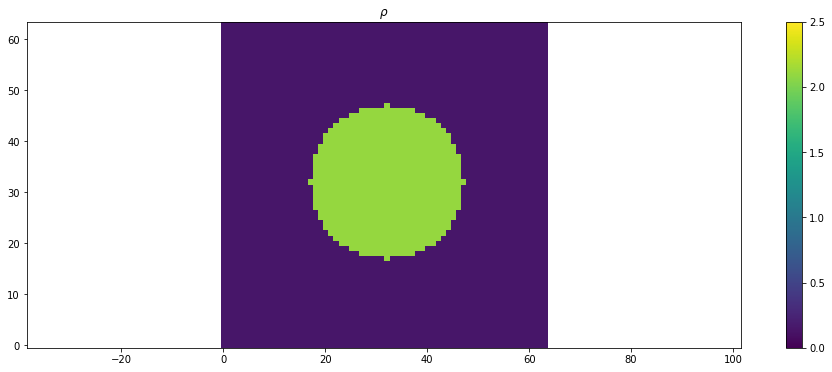

In [11]:
init()
plot_ρs()

### Check the first time step against reference data

The reference data was obtained with the [sample code](https://github.com/lbm-principles-practice/code/blob/master/chapter9/shanchen.cpp) after making the following changes:
```c++
const int nsteps = 1000;
const int noutput = 1;
```

Remove the next cell if you changed the parameters at the beginning of this notebook.

In [12]:
init()
time_loop(1)
ref = np.array([0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.136756, 0.220324, 1.2382, 2.26247, 2.26183, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.26183, 2.26247, 1.2382, 0.220324, 0.136756, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15])

assert np.allclose(dh.gather_array(ρ.name)[N//2], ref)

### Run the simulation until converged

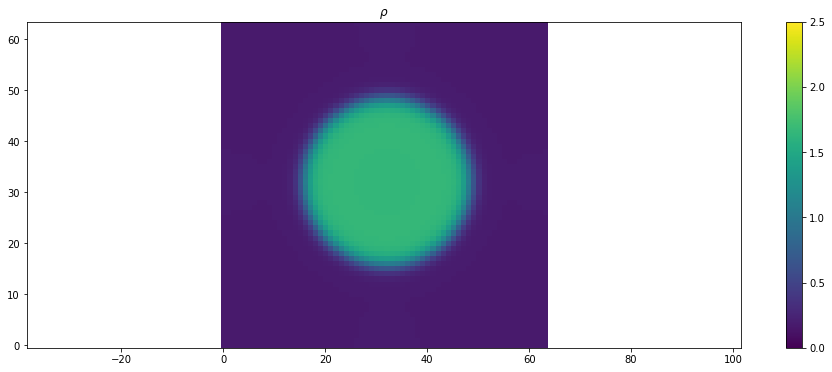

In [13]:
init()
time_loop(1000)
plot_ρs()